<a href="https://colab.research.google.com/github/fredericpoitevin/tseries-deconvolution/blob/master/Deconvolution_of_Michael_coronavirus_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We are interested in the following scenario:
We have access to two cumulative time-series that we call cause (or _cases_ $C(t)$ the total number of cases at time $t$) and consequence (or _deaths_ $D(t) $ the total number of deaths at time $t$). We assume that consequence is cause convolved with an unknown kernel $K$, and we are interested in inferring the kernel function, or at least its parameters.

Formally, 

$$\frac{\partial D}{\partial \tau}|_{\tau=t} = \sum_{s=0}^{t} K(t-s)\frac{\partial C}{\partial \tau}|_{\tau=s}$$

We have access to samples of the cumulative time-series at fixed time intervals $\Delta t$, we can thus discretize the above equation with finite difference. For $i \geq 1$, we introduce $f_{i} = \frac{F(i\Delta t) - F((i-1)\Delta t)}{\Delta t}$:

$$d_{i} = \sum_{j=1}^{i}k_{ij}c_{j}$$

# Dataset curated by Michael
We recommend going through the **Illustrative example** below before reading this.

We begin here by importing the data and zero-pad it before the time origin.

In [4]:
uploaded = files.upload()

Saving tseries_sigmoid-v2.csv to tseries_sigmoid-v2.csv


In [13]:
data        = np.genfromtxt('/content/tseries_sigmoid-v2.csv', delimiter=',', comments='#')
ndays       = data.shape[0]
data_pad    = np.zeros(data.shape)
data_padded = np.stack((data_pad, data), axis=0).reshape(2*data.shape[0], data.shape[1])
cases  = data_padded[:,2]
deaths = data_padded[:,3]
print('Total number of days centered on the time origin: {}'.format(data_padded.shape[0]))

Total number of days centered on the time origin: 208


Having loaded the cases and deaths, we proceed to find the convolution kernel between the two:

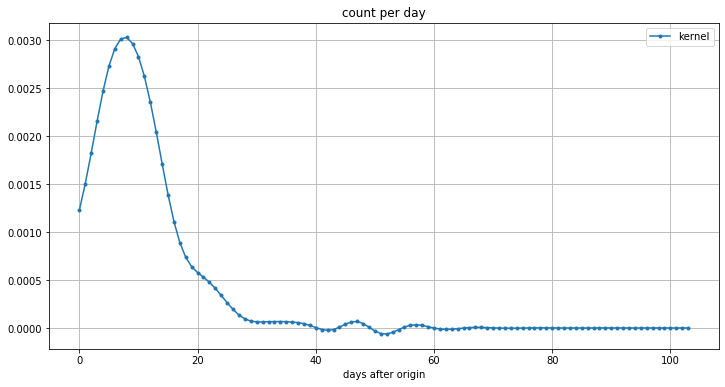

In [161]:
kernel = wiener_deconvolution(ndays, c=cases, d=deaths, nsr=1e6)
display(ndays, c=kernel, labels=['kernel'], show_cumul=False)

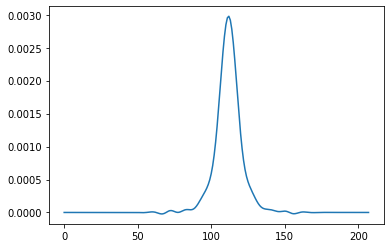

In [188]:
plt.plot(kernel)

We can measure the discrepancy between the actual deaths and the ones computed by convoluting the cases with the newly obtained kernel:

>>> RMS = 2.66719
>>> Smoothness = 0.00385
>>> SCORE = 2.67104


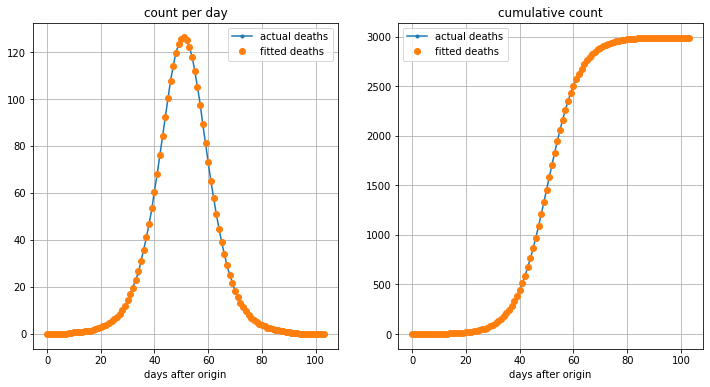

In [162]:
rms, smoothness, score = measure_rms(ndays, c=cases, k=kernel, d=deaths)

NSR = 100.0
>>> RMS = 2.30e+00
>>> Smoothness = 2.01e-02
>>> SCORE = 2.32e+00


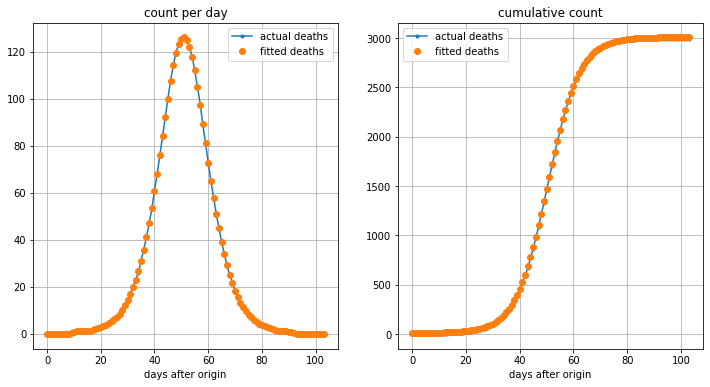

NSR = 316.22776601683796
>>> RMS = 2.38e+00
>>> Smoothness = 2.37e-03
>>> SCORE = 2.38e+00


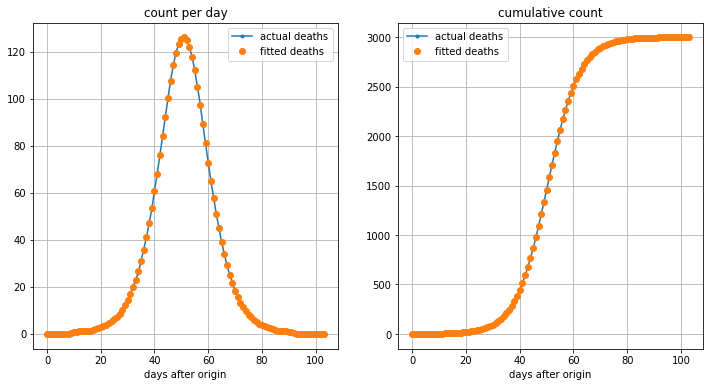

NSR = 1000.0
>>> RMS = 2.42e+00
>>> Smoothness = 2.97e-04
>>> SCORE = 2.42e+00


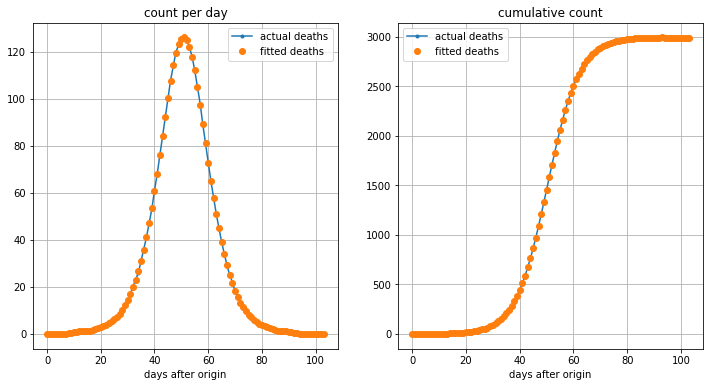

NSR = 3162.2776601683795
>>> RMS = 2.46e+00
>>> Smoothness = 4.48e-05
>>> SCORE = 2.46e+00


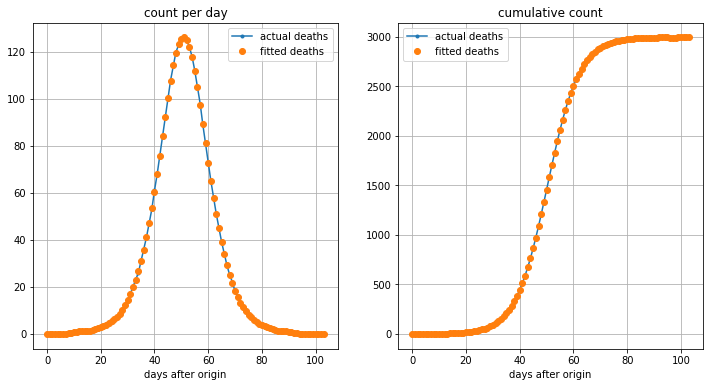

NSR = 10000.0
>>> RMS = 2.49e+00
>>> Smoothness = 8.34e-06
>>> SCORE = 2.49e+00


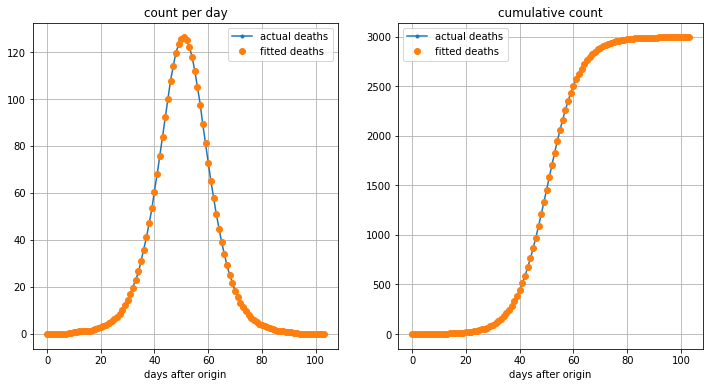

NSR = 31622.776601683792
>>> RMS = 2.52e+00
>>> Smoothness = 2.02e-06
>>> SCORE = 2.52e+00


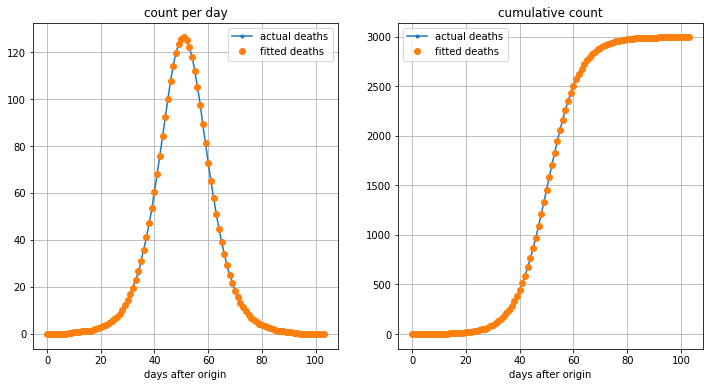

NSR = 100000.0
>>> RMS = 2.57e+00
>>> Smoothness = 5.75e-07
>>> SCORE = 2.57e+00


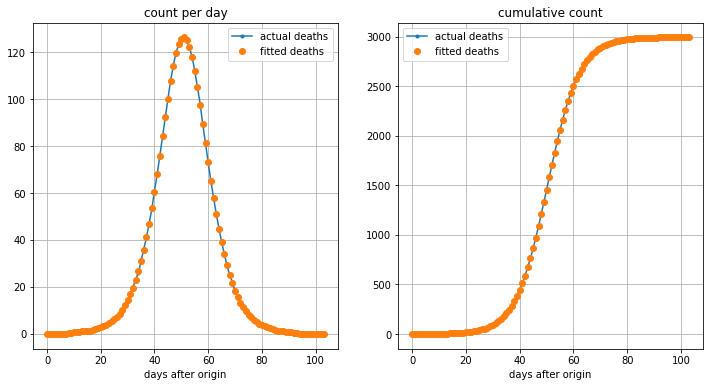

NSR = 316227.7660168379
>>> RMS = 2.61e+00
>>> Smoothness = 1.78e-07
>>> SCORE = 2.61e+00


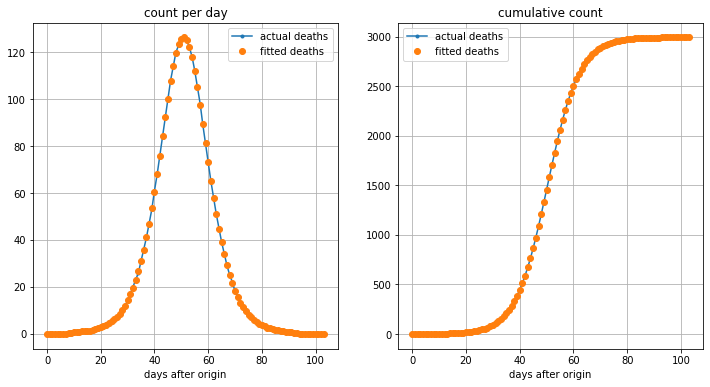

NSR = 1000000.0
>>> RMS = 2.67e+00
>>> Smoothness = 8.89e-08
>>> SCORE = 2.67e+00


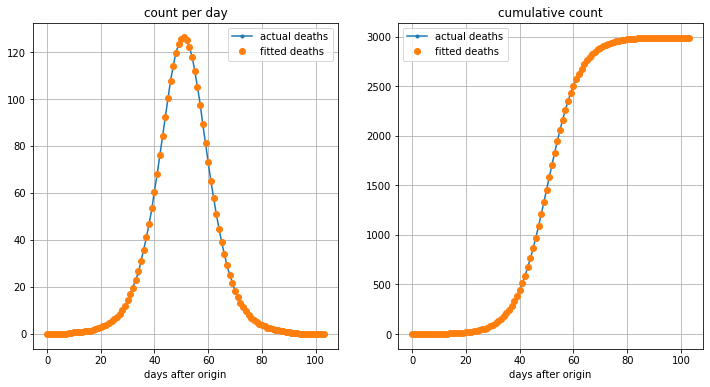

NSR = 3162277.6601683795
>>> RMS = 2.84e+00
>>> Smoothness = 6.73e-08
>>> SCORE = 2.84e+00


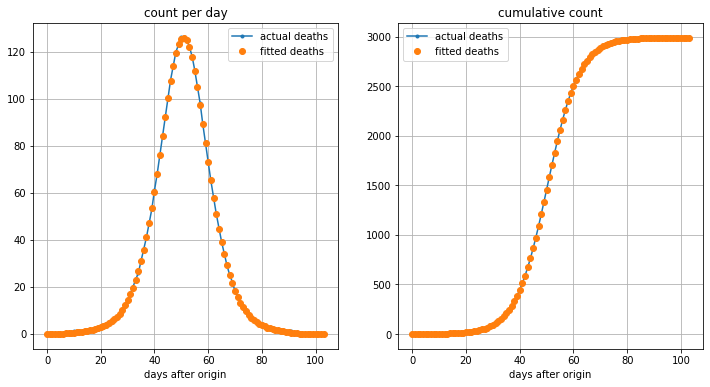

NSR = 10000000.0
>>> RMS = 3.84e+00
>>> Smoothness = 5.49e-08
>>> SCORE = 3.84e+00


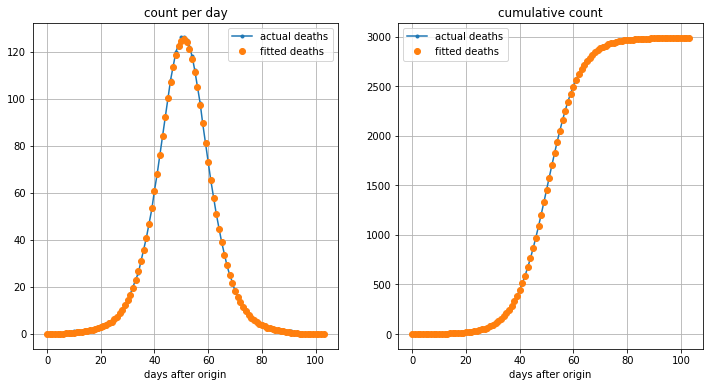

In [186]:
nsr_list = np.logspace(2, 7, num=11)
rms_list = []
smoothness_list = []
score_list = []
#
for nsr in nsr_list:
  print('NSR = {}'.format(nsr))
  kernel = wiener_deconvolution(ndays, c=cases, d=deaths, nsr=nsr)
  rms, smoothness, score = measure_rms(ndays, c=cases, k=kernel, d=deaths)
  rms_list.append(rms)
  smoothness_list.append(smoothness)
  score_list.append(score)

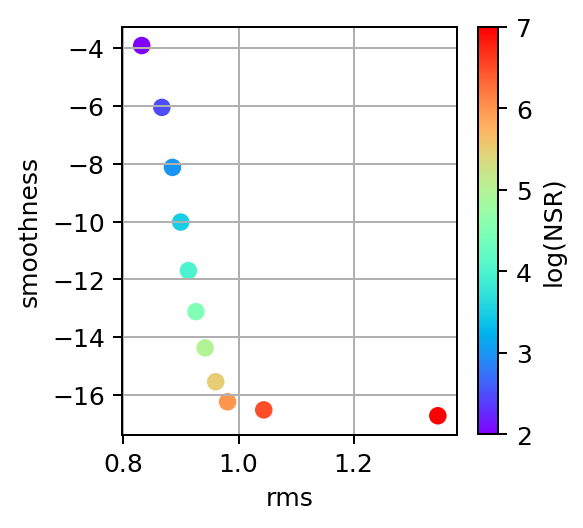

In [187]:
fig, ax = plt.subplots(figsize=(3,3),dpi=180)
sc = ax.scatter(np.log(rms_list), np.log(smoothness_list), c=np.log10(nsr_list), cmap='rainbow')
#ax.set_xlim(2.4,3)
#ax.set_ylim(2.5,3)
#ax.set_xscale('log')
ax.set_xlabel('rms')
#ax.set_yscale('log')
ax.set_ylabel('smoothness')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('log(NSR)')
plt.grid()
plt.show()

In [0]:
kernel_gaussian_sum_fitted, params = fit_kernel_v2(kernel, gaussian_sum, p0=(0.003,0.0003,0.0001,
                                                                             5,5,10,
                                                                             ndays+10,ndays+15,ndays+40))

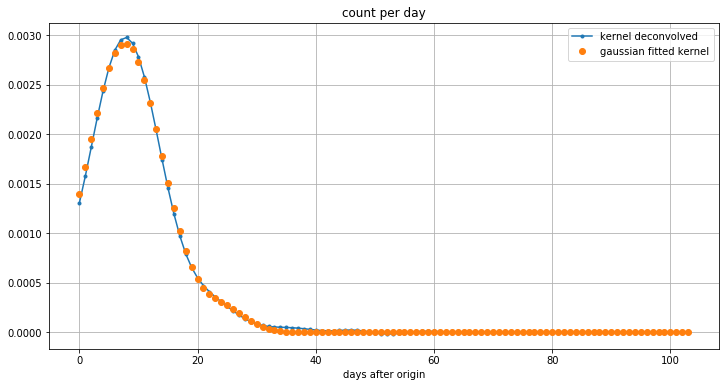

In [247]:
display(ndays, c=kernel, d=kernel_gaussian_fitted, 
        labels=['kernel deconvolved','gaussian fitted kernel'], show_cumul=False)

>>> RMS = 4.07


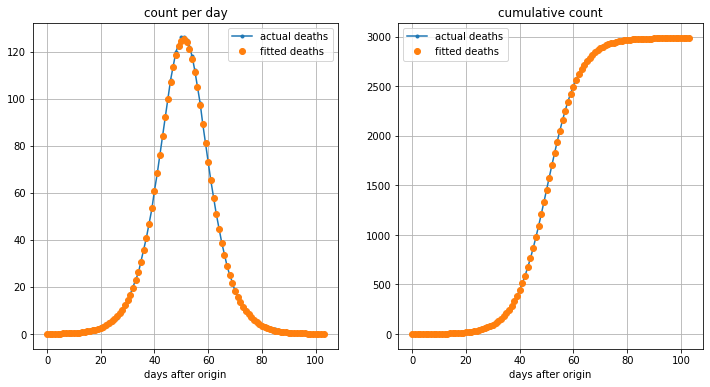

In [248]:
rms = measure_rms(ndays, c=cases, k=kernel_gaussian_sum_fitted, d=deaths)

Let's find the best gaussian kernel that fits the newly obtained kernel:

> Height: 0.002884787886083115, Center: 7.78565732148185, Width: 6.529093938752163


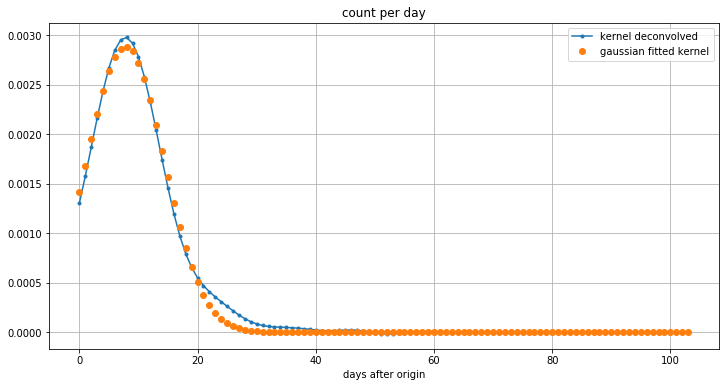

In [8]:
kernel_gaussian_fitted, params = fit_kernel(kernel, p0=(0.003,ndays+10,5))
print('> Height: {}, Center: {}, Width: {}'.format(params[0], params[1]-ndays, params[2]))
display(ndays, c=kernel, d=kernel_gaussian_fitted, 
        labels=['kernel deconvolved','gaussian fitted kernel'], show_cumul=False)

What is the discrepancy between the actual deaths and the ones predicted by the gaussian kernel:

>>> RMS = 239.03453
>>> Smoothness = 0.00136
>>> SCORE = 239.03589


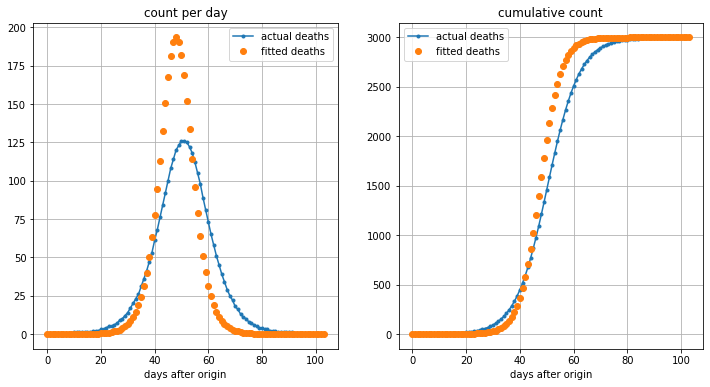

In [51]:
rms = measure_rms(ndays, c=cases, k=kernel_gaussian_fitted, d=deaths)

# Illustrative example

## Synthesizing the dataset

First, let's define the parameters below:

In [0]:
ndays            = 50
cases_amplitude  = 100
cases_center     = 15
cases_width      = 5
kernel_amplitude = 0.05
kernel_center    = 5
kernel_width     = 2

Now let's synthesize the cases time-series as well as the kernel. 

*Important note: we look at the (ndays:2ndays) period of time, but we actually work on the full (0:2ndays) period*

Convolve to predict the deaths, and display the cases and resulting deaths.

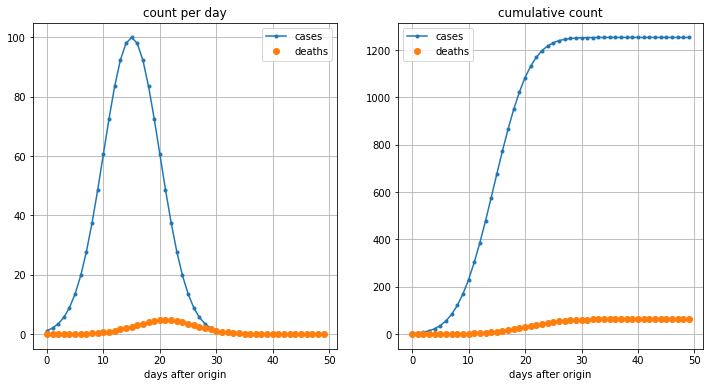

In [4]:
t = define_time_points(ndays)
cases  = synthesize_tseries(t, gaussian, cases_amplitude, cases_width, cases_center)
kernel = synthesize_tseries(t, gaussian, kernel_amplitude, kernel_width, kernel_center, normalize=True)
deaths = np.convolve(kernel, cases, mode='same')
display(ndays, c=cases, d=deaths, labels=['cases','deaths'])

## Kernel deconvolution from synthetic data

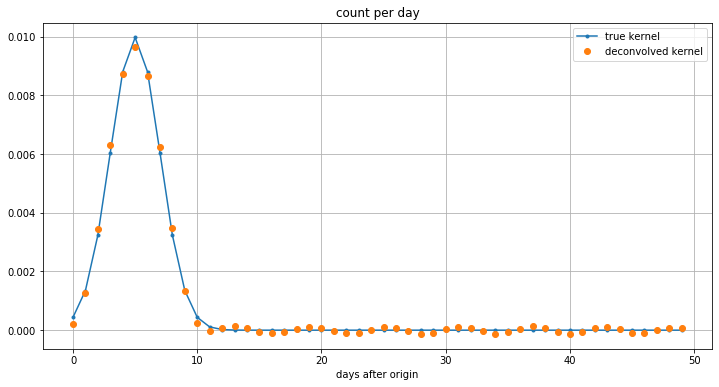

In [5]:
kernel_deconvolved = wiener_deconvolution(ndays, c=cases, d=deaths, nsr=1e-7)
display(ndays, c=kernel, d=kernel_deconvolved, labels=['true kernel','deconvolved kernel'], show_cumul=False)

Let's now measure the discrepancy between the actual and fitted deaths:

>>> RMS = 0.00002


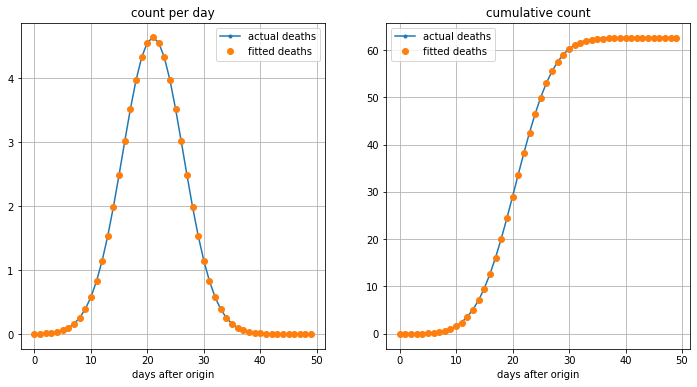

In [8]:
rms = measure_rms(ndays, c=cases, k=kernel_deconvolved, d=deaths)

Let's fit a parametric function to the deconvolved kernel

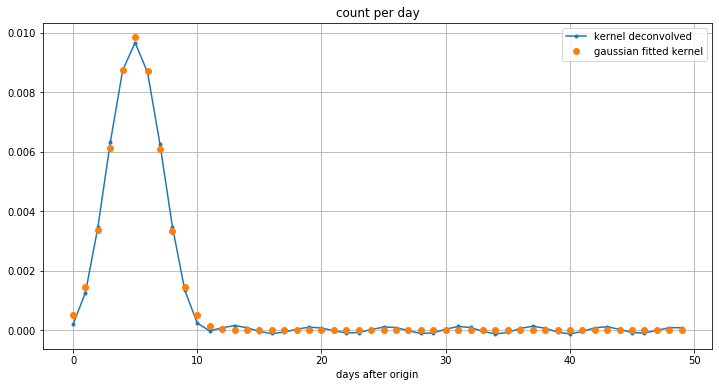

In [10]:
kernel_gaussian_fitted, params = fit_kernel(kernel_deconvolved, gaussian, p0=(0.01,ndays+5,5))
display(ndays, c=kernel_deconvolved, d=kernel_gaussian_fitted, 
        labels=['kernel deconvolved','gaussian fitted kernel'], show_cumul=False)


And let's now measure the discrepancy between the actual deaths and the one fitted with the gaussian-fitted kernel:

>>> RMS = 0.10986


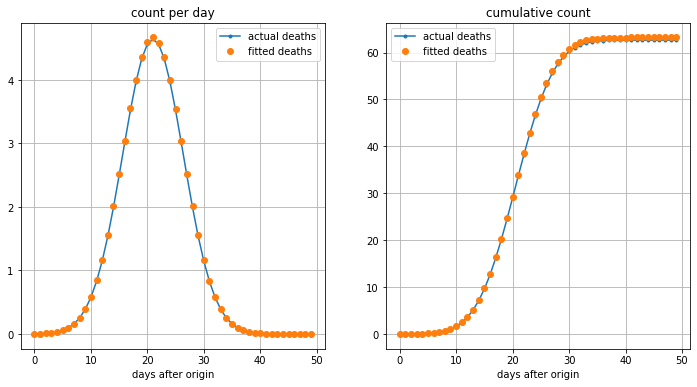

In [11]:
rms = measure_rms(ndays, c=cases, k=kernel_gaussian_fitted, d=deaths)

# Toolkit

In [0]:
# load all libraries
import os
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files
from scipy.optimize import curve_fit


In [0]:
def fit_kernel(kernel, function, p0=None):
  popt, pcov = curve_fit(function, np.arange(kernel.shape[0]), kernel, p0=p0)
  kernel_fitted = function(np.arange(kernel.shape[0]), *popt)
  return kernel_fitted, popt

def gaussian_sum(x,*params, normalize=False):
  n=np.int(len(params)/3)
  amplitude = params[:n]
  sigma     = params[n:2*n]
  center    = params[2*n:3*n]
  y = np.zeros(x.shape)
  for i in np.arange(n):
    y += gaussian(x, amplitude[i], sigma[i], center[i])
  return y

def gaussian(x, *params, normalize=False):
  amplitude = params[0]
  sigma     = params[1]
  center    = params[2]
  if normalize:
    amplitude /= np.sqrt(2*np.pi)*sigma
  y = amplitude*np.exp(-0.5*((x-center)/sigma)**2)
  return y

def synthesize_tseries(t, function, *params, normalize=False):
  """synthesize_tseries(t, function, *params)
  Arguments:
  ---------
  - t: time-points (array. Mandatory)
  - function: shape of the distribution
  - params: parameters of function 
  Returns:
  -------
  tseries: function evaluated at t
  """
  tseries = function(t, *params, normalize=normalize)
  return tseries

def measure_rms(ndays, c=None, k=None, d=None, do_display=True, labels=['actual deaths','fitted deaths']):
  """rms
  """
  d_new = np.convolve(k,c,mode='same')
  rms = np.linalg.norm(d_new[ndays:]-d[ndays:])
  smoothness = np.sum(np.abs(np.convolve(k, [1,-2,1], 'same'))**2)
  print('>>> RMS = {:.2e}\n>>> Smoothness = {:.2e}\n>>> SCORE = {:.2e}'.format(rms, smoothness, rms+smoothness))
  if do_display:
    display(ndays, c=d, d=d_new, labels=labels)
  return rms,smoothness,rms+smoothness

def wiener_deconvolution(ndays,c=None,d=None,nsr=0.0):
  """wiener_deconvolution
  """
  c_fft = np.fft.fft(c)
  d_fft = np.fft.fft(d)
  k_fft = d_fft*np.conj(c_fft)/(np.abs(c_fft)**2 + nsr)
  return np.roll(np.real(np.fft.ifft(k_fft)),ndays-1)

def display(ndays,c=None, d=None, labels=['cause', 'consequence'], show_cumul=True):
  ncol=1
  if show_cumul:
    ncol=2
  trange=np.arange(ndays)
  tzero = ndays
  fig = plt.figure(figsize=(12,6))
  plt.subplot(1,ncol,1)
  plt.title('count per day')
  plt.xlabel('days after origin')
  if c is not None:
    plt.plot(trange,c[tzero:], '.-', label=labels[0])
  if d is not None:
    plt.plot(trange,d[tzero:], 'o', label=labels[1])
  plt.grid()
  plt.legend()
  if show_cumul:
    plt.subplot(1,ncol,2)
    plt.title('cumulative count')
    plt.xlabel('days after origin')
    if c is not None:
      plt.plot(trange,np.cumsum(c)[tzero:], '.-', label=labels[0])
    if d is not None:
      plt.plot(trange,np.cumsum(d)[tzero:], 'o', label=labels[1])
    plt.grid()
    plt.legend()
  plt.show()

def define_time_points(ndays):
  """define_time_points(ndays)
  """
  return np.arange(-ndays,ndays)